In [1]:
import sys
sys.path.append('.')

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
print(torch.__version__)

from src.dataset import ImageDataset
from src.config import Config

cfg = Config()

2.2.2+cu121
Mean: [0.51393522 0.39408562 0.4046115 ], Std: [0.21051145 0.21676759 0.20957546]


In [3]:
# Training dataset
train_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=True, transform=cfg.TRANSFORM_TRAIN)
# Testing/validation dataset
test_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=False, transform=cfg.TRANSFORM_TEST)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 151
Number of testing samples: 70


In [4]:
from torch.utils.data import DataLoader

# no num_workers or some weird stuff
train_dataloader_display = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_dataloader_display = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

Feature batch shape: torch.Size([1, 3, 80, 80])
Labels batch shape: torch.Size([1])
Label: 0


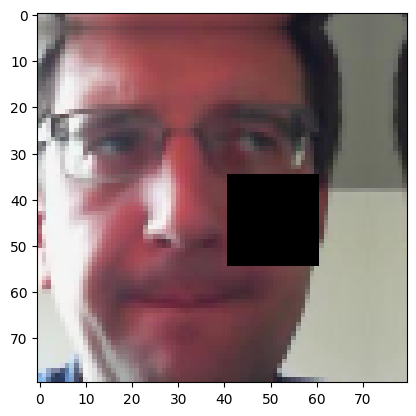

In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader_display))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [6]:
# no num_workers or some weird stuff
train_dataloader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, pin_memory=True)

In [16]:
from torch.optim import SGD, Adam
from src.models.resnet9 import ResNet9

device = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu') - mx250 throwing bsod (:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print('Using CPU')

model = ResNet9(3, cfg.NUM_CLASSES).to(device)
optimizer_sgd = SGD(model.parameters(), lr=cfg.MAX_LR, momentum=cfg.MOMENTUM, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)

Using CPU


In [17]:

# Example input
batch_size = 32
input_tensor = torch.randn(batch_size, 3, 32, 32).to(device)

# Forward pass
output = model(input_tensor)

In [21]:
from src.trainmodel import train

print(f"Training on {len(train_dataset)} samples and validating on {len(test_dataset)} samples")
history = train(model, train_dataloader, test_dataloader, cfg.EPOCHS, optimizer_sgd,
       device, cfg, grad_clip=cfg.GRAD_CLIP, verbose=True)

Training on 151 samples and validating on 70 samples
	Batch: 1/10 | Loss: 0.1527
	Batch: 2/10 | Loss: 0.1307
	Batch: 3/10 | Loss: 0.1439
	Batch: 4/10 | Loss: 0.3847
	Batch: 5/10 | Loss: 0.2017
	Batch: 6/10 | Loss: 0.3318
	Batch: 7/10 | Loss: 0.1984
	Batch: 8/10 | Loss: 0.0713
	Batch: 9/10 | Loss: 0.1738
	Batch: 10/10 | Loss: 0.0979
[Epoch: 01/30] - 21.91s | LR: 0.001000 | Train Loss: 0.1887 | Train Acc: 90.00 | Test Loss: 1.4530 | Test Acc: 30.00
	Batch: 1/10 | Loss: 0.1256
	Batch: 2/10 | Loss: 0.2907
	Batch: 3/10 | Loss: 0.1099
	Batch: 4/10 | Loss: 0.1116
	Batch: 5/10 | Loss: 0.0961
	Batch: 6/10 | Loss: 0.1622
	Batch: 7/10 | Loss: 0.2090
	Batch: 8/10 | Loss: 0.1045
	Batch: 9/10 | Loss: 0.0584
	Batch: 10/10 | Loss: 0.0771
[Epoch: 02/30] - 22.70s | LR: 0.001000 | Train Loss: 0.1345 | Train Acc: 91.25 | Test Loss: 0.3403 | Test Acc: 81.43
	Batch: 1/10 | Loss: 0.1484
	Batch: 2/10 | Loss: 0.1586
	Batch: 3/10 | Loss: 0.1241
	Batch: 4/10 | Loss: 0.3521
	Batch: 5/10 | Loss: 0.1595
	Batch: 6/1

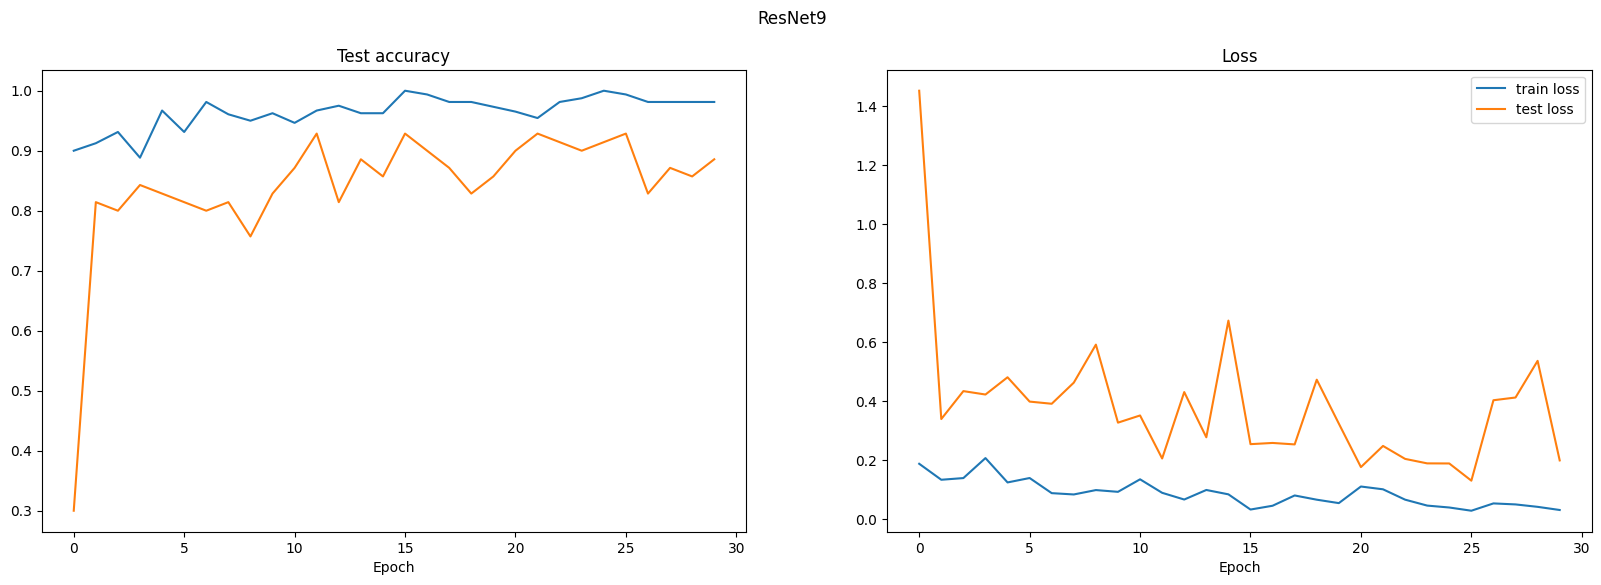

In [22]:
from src.utils import plot_graphs

plot_graphs(history, "ResNet9")